# Preamble

In [1]:
%matplotlib widget

from matplotlib import colormaps

import os, glob, pathlib
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

from loky import get_reusable_executor
import dill as pickle

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

def fs1(alpha):
    """
    fs,1 in MD table 8.4 p. 331
    (1/8)*(2*α*D+α**2*D^2)*b^(0)_(1/2)(α)
    """
    return 0.125 * (2*alpha*Db(0.5,0,alpha) + alpha**2*D2b(0.5,0,alpha))

def fs2(alpha):
    """ 
    fs,2 in MD table 8.4 p. 331
    (1/4)*(2-2*α*D-α**2*D^2)*b^(1)_(1/2)(α)
    """
    return 0.25*(2*b(0.5,1,alpha)-2*alpha*Db(0.5,1,alpha)-alpha**2*D2b(0.5,1,alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val = f27lc(alpha0, 2)
f2val = f31lc(alpha0, 2)
f3val = fs1(alpha0)
f4val = fs2(alpha0)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [2]:
f1val, f2val, f3val, f4val

# Poisson Bracket

In [3]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

# Hamiltonian and Canonical Variables

In [4]:

a1, a2, e1, e2, mu2, l1, l2, pom1, pom2, f1, f2, f3, f4, j, om1, om2 = symbols(
    r"a_1 a_2 e_1 e_2 mu_2 lambda_1 lambda_2 varpi_1 varpi_2 f_1 f_2 f_3 f_4 j \omega_{1\rm{e}} \omega_{2\rm{e}}"
)
q = symbols(r"q", positive=True)
calH = (
    -q / (2 * a1)
    - 1 / (2 * a2)
    - q* mu2/ a2
    * f1 * e1 * cos((j + 1) * l2 - j * l1 - pom1)
    - q* mu2/ a2* f2 * e2 * cos((j + 1) * l2 - j * l1 - pom2)
    -om1*Rational(1,2)*q*sqrt(a1)*e1**2
    -om2*Rational(1,2)*sqrt(a2)*e2**2
    -q*mu2/a2*f3*(e1**2+e2**2) -q*mu2/a2*f4*e1*e2*cos(pom1-pom2)
)
calH

In [5]:
L1, L2, G1, G2 = symbols("Lambda_1 Lambda_2 Gamma_1 Gamma_2", positive=True)
g1, g2 = symbols("gamma_1 gamma_2")

In [6]:
def orbelts_to_delaunay(expr):
    return expr.subs(
        {
            e1: sqrt(2 * G1 / L1),
            e2: sqrt(2 * G2 / L2),
            a1: L1**2   / q**2,
            a2: L2**2,
            pom1: -g1,
            pom2: -g2,
        }
    )


def delaunay_to_orbelts(expr):
    return expr.subs(
        {
            g1: -pom1,
            g2: -pom2,
            G1: Rational(1, 2) * L1 * e1**2,
            G2: Rational(1, 2) * L2 * e2**2,
            L1: q*sqrt(a1),
            L2: sqrt(a2),
        }
    )

# $\theta_1$ and $\theta_2$ as action variables

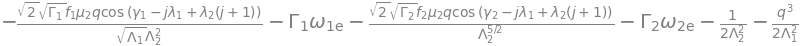

In [7]:

H1 = orbelts_to_delaunay(calH).subs(
    {sqrt(L1**2): L1, sqrt(L2**2): L2, f3:0, f4:0}
)
H1

In [8]:
J1, th1, J2, th2, K1, k1, K2, k2 = symbols("J_1 theta_1 J_2 theta_2 K_1 k_1 K_2 k_2")

genF1 = {}
genF1["func"] = J1*((j+1)*l2-j*l1+g1) + J2*((j+1)*l2-j*l1+g2) + K1*l1 + K2*l2
genF1["th1"] = genF1["func"].diff(J1)
genF1["th2"] = genF1["func"].diff(J2)
genF1["k1"] = genF1["func"].diff(K1)
genF1["k2"] = genF1["func"].diff(K2)
genF1["G1"] = genF1["func"].diff(g1)
genF1["G2"] = genF1["func"].diff(g2)
genF1["L1"] = genF1["func"].diff(l1)
genF1["L2"] = genF1["func"].diff(l2)

invert_coords = solve([genF1["th1"]-th1,genF1["th2"]-th2,genF1["k1"]-k1,genF1["k2"]-k2],[g1,g2,l1,l2])
invert_moms = solve([genF1["G1"]-G1,genF1["G2"]-G2,genF1["L1"]-L1,genF1["L2"]-L2],[J1,J2,K1,K2])
genF1["l1"] = invert_coords[l1]
genF1["l2"] = invert_coords[l2]
genF1["g1"] = invert_coords[g1]
genF1["g2"] = invert_coords[g2]
genF1["J1"] = invert_moms[J1]
genF1["J2"] = invert_moms[J2]
genF1["K1"] = invert_moms[K1] 
genF1["K2"] = invert_moms[K2] 

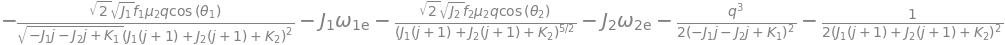

In [9]:
H2 = H1.subs({
    l1:genF1["l1"],
    l2:genF1["l2"],
    g1:genF1["g1"],
    g2:genF1["g2"],
}).simplify(deep=True).subs({
    G1:genF1["G1"],
    G2:genF1["G2"],
    L1:genF1["L1"],
    L2:genF1["L2"],
})
H2

In [10]:
H2_0 = H2.subs(mu2,0)

In [11]:
H3_0 = (
    H2_0.subs({J1: 0, J2: 0})
    + H2_0.taylor_term(1, J1).subs(J2, 0)
    + H2_0.taylor_term(1, J2).subs(J1, 0)
    + H2_0.taylor_term(1, J1).taylor_term(1, J2)
    + H2_0.taylor_term(2, J1).subs(J2, 0).simplify()
    + H2_0.taylor_term(2, J2).subs(J1, 0).simplify()
)

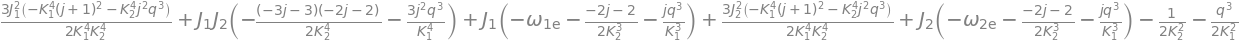

In [12]:
H3_0

In [13]:
H3_0_rewrite = -Rational(3,2)*((j+1)**2/(K2**4) + j**2*q**3/(K1**4))*(J1+J2)**2 -J1*om1 - J2*om2 + ((j+1)/K2**3-j*q**3/K1**3)*(J1+J2) - 1/(2*K2**2) - q**3/(2*K1**2)

In [14]:
simplify(H3_0 - H3_0_rewrite)

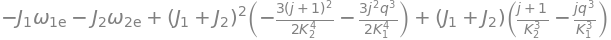

In [15]:
H4_0 = H3_0_rewrite
H4_0 = H4_0 + 1/(2*K2**2)+q**3/(2*K1**2)
H4_0 

In [16]:
X1, X2, Y1, Y2 = symbols("X1 X2 Y1 Y2")
X1_expr, Y1_expr = sqrt(2*J1)*sin(th1), sqrt(2*J1)*cos(th1)
X2_expr, Y2_expr = sqrt(2*J2)*sin(th2), sqrt(2*J2)*cos(th2)
PB = PoissonBracket([th1,th2],[J1,J2])
PB(Y1_expr,X1_expr).trigsimp()
PB(Y2_expr,X2_expr).trigsimp()

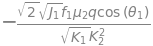

In [17]:
costerm1 = fraction(H2.coeff(cos(th1)))[0]/fraction(H2.coeff(cos(th1)))[1].subs({J1:0,J2:0})*cos(th1)
costerm1

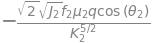

In [18]:
costerm2 = fraction(H2.coeff(cos(th2)))[0]/fraction(H2.coeff(cos(th2)))[1].subs({J1:0,J2:0})*cos(th2)
costerm2

In [19]:
H4 = H4_0 + costerm1 + costerm2

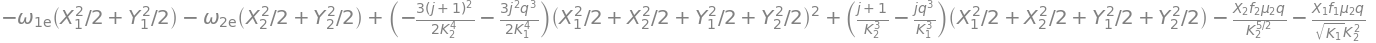

In [20]:
H5 = H4.subs(
    {
        cos(th1): X1 / sqrt(2 * J1),
        cos(th2): X2 / sqrt(2 * J2),
        sin(th1): Y1 / sqrt(2 * J1),
        sin(th2): Y2 / sqrt(2 * J2),
        J1: Rational(1, 2) * (X1**2 + Y1**2),
        J2: Rational(1, 2) * (X2**2 + Y2**2),
    }
)
H5

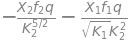

In [56]:
g1, g2 = f1/sqrt(K1), f2/sqrt(K2)
Psi = 1/sqrt((g1**2+g2**2)) *Matrix([[g1,g2],[-g2,g1]])
#Psi = Matrix([[g1,g2],[-g2,g1]])
M = Matrix(BlockDiagMatrix(Psi,Psi))
#M = Matrix(BlockDiagMatrix(Psi,Matrix([[1,0],[0,1]])))
M

⎡           f₁                       f₂                                       
⎢───────────────────────  ───────────────────────             0               
⎢            ___________              ___________                             
⎢           ╱   2     2              ╱   2     2                              
⎢  ____    ╱  f₂    f₁      ____    ╱  f₂    f₁                               
⎢╲╱ K₁ ⋅  ╱   ─── + ───   ╲╱ K₂ ⋅  ╱   ─── + ───                              
⎢       ╲╱     K₂    K₁          ╲╱     K₂    K₁                              
⎢                                                                             
⎢          -f₂                       f₁                                       
⎢───────────────────────  ───────────────────────             0               
⎢            ___________              ___________                             
⎢           ╱   2     2              ╱   2     2                              
⎢  ____    ╱  f₂    f₁      ____    ╱  f₂    f₁     

In [57]:
X = Matrix([X1,X2,Y1,Y2])
X

⎡X₁⎤
⎢  ⎥
⎢X₂⎥
⎢  ⎥
⎢Y₁⎥
⎢  ⎥
⎣Y₂⎦

In [58]:
W = M*X
w1_expr = W[0]
w2_expr = W[1]
W1_expr = W[2]
W2_expr = W[3]
(w1_expr**2+w2_expr**2+W1_expr**2+W2_expr**2).simplify().subs({X1:X1_expr,X2:X2_expr,Y1:Y1_expr,Y2:Y2_expr}).trigsimp()

In [59]:
w1, w2, W1, W2 = symbols("w_1 w_2 W_1 W_2")

In [60]:
W = Matrix([w1,w2,W1,W2])
X_expr = M.inv()*W
X_expr

⎡                     ___________                        ___________⎤
⎢                    ╱   2     2                        ╱   2     2 ⎥
⎢  ____             ╱  f₂    f₁          ____          ╱  f₂    f₁  ⎥
⎢╲╱ K₁ ⋅K₂⋅f₁⋅w₁⋅  ╱   ─── + ───    K₁⋅╲╱ K₂ ⋅f₂⋅w₂⋅  ╱   ─── + ─── ⎥
⎢                ╲╱     K₂    K₁                    ╲╱     K₂    K₁ ⎥
⎢──────────────────────────────── - ────────────────────────────────⎥
⎢             2        2                         2        2         ⎥
⎢        K₁⋅f₂  + K₂⋅f₁                     K₁⋅f₂  + K₂⋅f₁          ⎥
⎢                                                                   ⎥
⎢                  f₂⋅w₁                     f₁⋅w₂                  ⎥
⎢         ─────────────────────── + ───────────────────────         ⎥
⎢                     ___________               ___________         ⎥
⎢                    ╱   2     2               ╱   2     2          ⎥
⎢           ____    ╱  f₂    f₁       ____    ╱  f₂    f₁           ⎥
⎢         ╲╱ K₂ ⋅  ╱

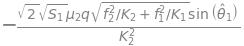

In [61]:
PB = PoissonBracket([X1,X2],[Y1,Y2])
display(PB(W1_expr,w1_expr).simplify())
display(PB(w1_expr,w2_expr).simplify())
display(PB(W1_expr,w2_expr).simplify())
display(PB(w1_expr,W2_expr).simplify())
display(PB(W2_expr,w2_expr).simplify())
display(PB(W1_expr,W2_expr).simplify())

In [62]:
(w1_expr**2 + w2_expr**2 + W1_expr**2 + W2_expr**2).simplify()

In [63]:
S1, S2, hth1, hth2 = symbols(r"S_1 S_2 \hat\theta_1 \hat\theta_2")

In [64]:
w1_expr_S, W1_expr_S = sqrt(2*S1)*sin(hth1), sqrt(2*S1)*cos(hth1)
w2_expr_S, W2_expr_S = sqrt(2*S2)*sin(hth2), sqrt(2*S2)*cos(hth2)

In [65]:
(w1_expr_S**2 + w2_expr_S**2 + W1_expr_S**2 + W2_expr_S**2).simplify()

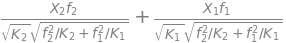

In [66]:
w1_expr

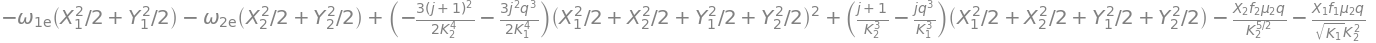

In [67]:
H5

In [68]:
X_expr

⎡                     ___________                        ___________⎤
⎢                    ╱   2     2                        ╱   2     2 ⎥
⎢  ____             ╱  f₂    f₁          ____          ╱  f₂    f₁  ⎥
⎢╲╱ K₁ ⋅K₂⋅f₁⋅w₁⋅  ╱   ─── + ───    K₁⋅╲╱ K₂ ⋅f₂⋅w₂⋅  ╱   ─── + ─── ⎥
⎢                ╲╱     K₂    K₁                    ╲╱     K₂    K₁ ⎥
⎢──────────────────────────────── - ────────────────────────────────⎥
⎢             2        2                         2        2         ⎥
⎢        K₁⋅f₂  + K₂⋅f₁                     K₁⋅f₂  + K₂⋅f₁          ⎥
⎢                                                                   ⎥
⎢                  f₂⋅w₁                     f₁⋅w₂                  ⎥
⎢         ─────────────────────── + ───────────────────────         ⎥
⎢                     ___________               ___________         ⎥
⎢                    ╱   2     2               ╱   2     2          ⎥
⎢           ____    ╱  f₂    f₁       ____    ╱  f₂    f₁           ⎥
⎢         ╲╱ K₂ ⋅  ╱

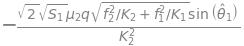

In [79]:

mu2*H5.coeff(mu2).subs({X1:X_expr[0],X2:X_expr[1]}).simplify().subs(w1,w1_expr_S)

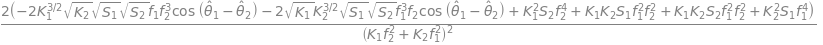

In [41]:
((X_expr[0] ** 2).expand().factor() + (X_expr[2] ** 2).expand().factor()).subs(
    {w1: w1_expr_S, w2: w2_expr_S, W1: W1_expr_S, W2: W2_expr_S}
).trigsimp()

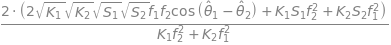

In [69]:
((X_expr[1]**2).expand().factor() + (X_expr[3]**2).expand().factor()).subs(
    {w1: w1_expr_S, w2: w2_expr_S, W1: W1_expr_S, W2: W2_expr_S}
).trigsimp()

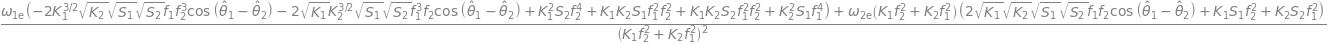

In [71]:
(Rational(1,2)*om1*((X_expr[0] ** 2).expand().factor() + (X_expr[2] ** 2).expand().factor()).subs(
    {w1: w1_expr_S, w2: w2_expr_S, W1: W1_expr_S, W2: W2_expr_S}
).trigsimp() +Rational(1,2)*om2*((X_expr[1]**2).expand().factor() + (X_expr[3]**2).expand().factor()).subs(
    {w1: w1_expr_S, w2: w2_expr_S, W1: W1_expr_S, W2: W2_expr_S}
).trigsimp() ).simplify().collect(2*sqrt(S1*S2)*cos(hth1-hth2))

In [266]:
(w1_expr**2 + w2_expr**2).simplify()

In [267]:
(W1_expr**2 + W2_expr**2).simplify()

In [ ]:
om1*(w1_expr**2 + w2_expr**2).simplify() - 

In [ ]:
H6 = -

# $\theta_1$ resonance

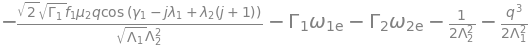

In [7]:
H1 = orbelts_to_delaunay(calH).subs(
    {sqrt(L1**2): L1, sqrt(L2**2): L2, f2: 0, f3: 0, f4: 0}
)
H1

In [8]:
J1, th1, K1, k1, K2, k2 = symbols("J_1 theta_1 K_1 k_1 K_2 k_2")
genF1 = {}
genF1["func"] = J1*((j+1)*l2-j*l1+g1) + K1*l1 + K2*l2

genF1["th1"] = genF1["func"].diff(J1)
genF1["k1"] = genF1["func"].diff(K1)
genF1["k2"] = genF1["func"].diff(K2)
genF1["G1"] = genF1["func"].diff(g1)
genF1["L1"] = genF1["func"].diff(l1)
genF1["L2"] = genF1["func"].diff(l2)

invert_coords = solve([genF1["th1"]-th1,genF1["k1"]-k1,genF1["k2"]-k2],[g1,l1,l2])
genF1["g1"] = invert_coords[g1]
genF1["l1"] = invert_coords[l1]
genF1["l2"] = invert_coords[l2]
invert_moms = solve([genF1["G1"]-G1,genF1["L1"]-L1,genF1["L2"]-L2],[J1,K1,K2])
genF1["J1"] = invert_moms[J1]
genF1["K1"] = invert_moms[K1]
genF1["K2"] = invert_moms[K2]

#for key in genF1.keys():
#    display(key,genF1[key])

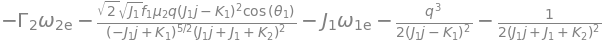

In [9]:
H2 = H1.subs({
    l1:genF1["l1"],
    l2:genF1["l2"],
    g1:genF1["g1"],
    G1:genF1["G1"],
    L1:genF1["L1"],
    L2:genF1["L2"],
}).simplify(deep=True)
H2

In [10]:
genF1["J1"], genF1["K1"], genF1["K2"]

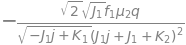

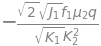

In [29]:
cos_coeff = H2.coeff(cos(th1)).powsimp()
display(cos_coeff)
cos_coeff = fraction(cos_coeff)[0] / fraction(cos_coeff)[1].subs({J1:  0})
display(cos_coeff)

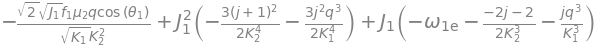

In [12]:
Hred1 = H2.subs({f1:0}).taylor_term(1,J1) + H2.subs({f1:0}).taylor_term(2,J1).powsimp() + cos_coeff*cos(th1)
Hred1

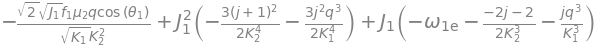

In [13]:
Hred1

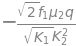

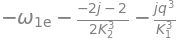

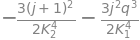

In [34]:
xi1 = Hred1.coeff(sqrt(J1)*cos(th1))
xi2 = Hred1.coeff(J1)
xi3 = Hred1.coeff(J1**2)
display(xi1,xi2,xi3)

In [21]:
display(Eq(K1,genF1["K1"]))
display(Eq(K2,genF1["K2"].collect(-G1).simplify()))

In [24]:
def plugin(expr):
    return expr.subs({j: 2, q: 0.5, f1: f1val, mu2: 1e-4})

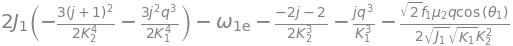

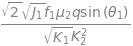

In [52]:
th1_dot_red = Hred1.diff(J1)
display(th1_dot_red)
J1_dot_red = Hred1.diff(th1)
display(J1_dot_red)

In [113]:
delaunay_to_orbelts(genF1["J1"]), delaunay_to_orbelts(genF1["K1"]), delaunay_to_orbelts(genF1["K2"])

In [114]:
K1_func = lambdify([e1, a1], plugin(delaunay_to_orbelts(genF1["K1"])))
K2_func = lambdify([e1, a1, a2], plugin(delaunay_to_orbelts(genF1["K2"])))

In [115]:
e1_J1 = solve(delaunay_to_orbelts(J1.subs({J1: genF1["J1"]}))-J1,e1)[1]
display(e1_J1)
e1_J1_func = lambdify([J1, a1], plugin(e1_J1))

In [135]:
th1_dot_red_func = lambdify(
    [J1, K1, K2, th1, om1],
    plugin(th1_dot_red),
)

a10val = alpha0*1.1
a20val = 1
e10val = 0.1
print(K1_func(e10val, a10val), K2_func(e10val, a10val, a20val))

def f(x):
    return th1_dot_red_func(
        x, K1_func(e10val, a10val), K2_func(e10val, a10val, a20val), np.pi, 0
    )


f(0.1)

0.4626905551070318 0.9931283580924698


/tmp/ipykernel_3328855/545250917.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(a10vals[J1_stable_min>0],e1_J1_func(J1_stable_max[J1_stable_min>0],a10vals[J1_stable_min>0]),c=c)


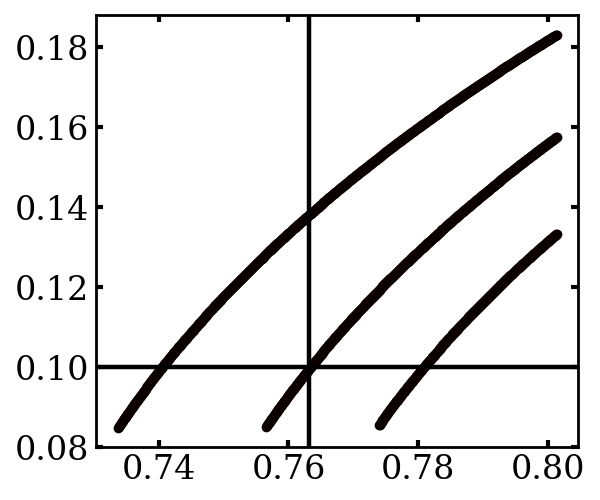

In [197]:
#plt.clf()
#e10vals = np.linspace(0.001,0.1,10)
e10vals = [0.1]
for jit, e10val in enumerate(e10vals):
    a10vals = np.linspace(0.95 * alpha0, 1.05 * alpha0, 1000)
    J1_stable_max = np.zeros(len(a10vals))
    J1_stable_min = np.zeros(len(a10vals))
    J1_unstable = np.zeros(len(a10vals))
    for kit, a10val in enumerate(a10vals):
        K1_val = K1_func(e10val, a10val)
        K2_val = K2_func(e10val, a10val, 0.95)

        def f(x):
            return th1_dot_red_func(x, K1_val, K2_val, np.pi, 0.1)

        J1_range = np.linspace(0.000001,0.9)
        fvals = f(J1_range)

        if np.max(fvals) > 0:
            it = np.argmax(fvals)
            sol = sp.optimize.root_scalar(f, bracket=[0.00000000000001,J1_range[it]])
            J1_stable_min[kit] = sol.root
            sol = sp.optimize.root_scalar(f, bracket=[J1_range[it],0.9])
            J1_stable_max[kit] = sol.root

        def f(x):
            return th1_dot_red_func(x, K1_val, K2_val, 0, 0)
        sol = sp.optimize.root_scalar(f, bracket=[0.000000000000001,0.9])
        J1_unstable[kit] = sol.root
    
    #plt.scatter(a10vals[J1_stable_min>0],e1_J1_func(J1_stable_min[J1_stable_min>0],a10vals[J1_stable_min>0]),c=c)
    plt.axhline(y=e10val,c="k")
    c = colormaps["hot"](jit/len(e10vals))
    plt.scatter(a10vals[J1_stable_min>0],e1_J1_func(J1_stable_max[J1_stable_min>0],a10vals[J1_stable_min>0]),c=c)
    #c = colormaps["viridis"](jit/len(e10vals))
    #plt.scatter(a10vals[J1_unstable>0],e1_J1_func(J1_unstable[J1_unstable>0],a10vals[J1_unstable>0]),c=c,s=2)
plt.axvline(x=alpha0)
plt.tight_layout()
plt.show()

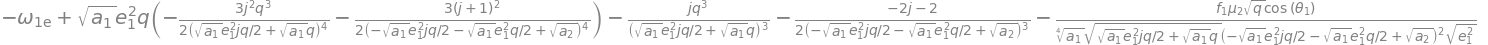

In [50]:
th1_dot_red_orbelts = delaunay_to_orbelts(
    th1_dot_red.subs(
        {
            J1: genF1["J1"],
            K1: genF1["K1"],
            K2: genF1["K2"],
        }
    )
)
th1_dot_red_orbelts

In [51]:
th1_dot_red_orbelts_func = lambdify(
    [e1, a1, a2, th1, om1],
    th1_dot_red_orbelts.subs({j: 2, q: 0.5, f1: f1val, mu2: 1e-4}),
)
th1_dot_red_orbelts_func(0.0001, alpha0, 1, np.pi, 0)

In [151]:
def f(x):
    return(th1_dot_red_orbelts_func(x,alpha0,1,0,0))
sol = sp.optimize.root_scalar(f, bracket=[0.00001,0.9])

In [152]:
a1vals = np.linspace(alpha0,1.1*alpha0,1000)
e1vals = np.zeros(len(a1vals))
for kit, a1val in enumerate(a1vals):
    def f(x):
        return(th1_dot_red_orbelts_func(x,a1val,1,0,0))

    sol = sp.optimize.root_scalar(f, bracket=[0.00001,0.9])
    e1vals[kit] = sol.root
    

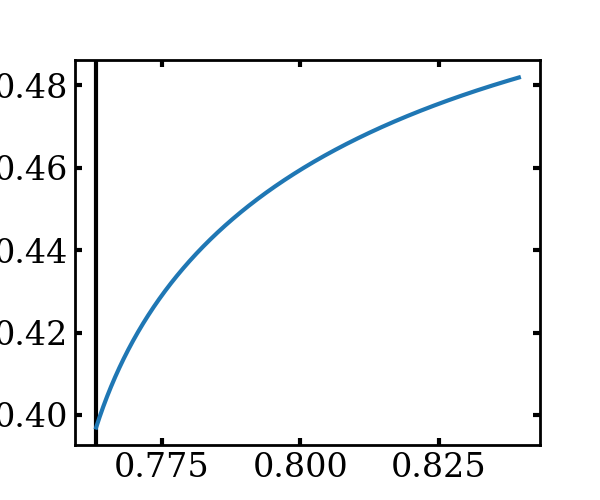

In [153]:
plt.clf()
plt.axvline(x=alpha0)
plt.plot(a1vals,  e1vals)
plt.show()

In [ ]:
Te1, Te2, Tm1, Tm2 = symbols(r"T_{\rm{e}1} T_{\rm{e}2} T_{\rm{m}1} T_{\rm{m}2}")
a1dot_dis = -a1   / Tm1 -   2 * e1 ** 2  * a1 / Te1
a2dot_dis = -a2   / Tm2 -   2 * e2 ** 2  * a2 / Te2

e1dot_dis = -e1   / Te1
e2dot_dis = -e2   / Te2

a1dot_dis,  e1dot_dis , a2dot_dis, e2dot_dis

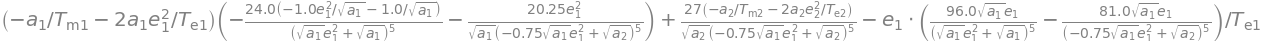

In [ ]:
J1_2_coeff_orbelts = delaunay_to_orbelts(
    Hred1.coeff(J1**2).subs({K2: genF1["K2"], K1: genF1["K1"]})
)
J1_2_coeff_orbelts_dot_dis = (
    J1_2_coeff_orbelts.diff(e1) * e1dot_dis
    + J1_2_coeff_orbelts.diff(a1) * a1dot_dis
    + J1_2_coeff_orbelts.diff(a2) * a2dot_dis
)
display(plugin(J1_2_coeff_orbelts_dot_dis))
J1_2_coeff_orbelts_dot_dis_func = lambdify(
    [e1, e2, a1, a2, Te1, Te2, Tm1, Tm2], plugin(J1_2_coeff_orbelts_dot_dis)
)

# Canonical transformations for numerical experiments

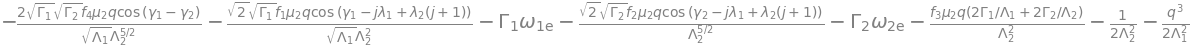

In [13]:
H1 = orbelts_to_delaunay(calH).subs({sqrt(L1**2):  L1 , sqrt(L2**2 ): L2})
H1

In [16]:
Th0, th0, K0, k0 = symbols("Theta_0 theta_0 K_0 k_0")

In [55]:
genF1 = {}
genF1["func"] = -Th0   * ( ( 1) +  1) *  l 2 - j *  l 1) + K0 * l2
genF1["L1"] = genF1["func"].diff(l1)
genF1["L2"] = genF1["func"].diff(l2)
genF1["th0"] = genF1["func"].diff(Th0)
genF1["k0"] = genF1["func"].diff(K0)


genF1["l2"] = solve(k0   genF1["k0"], ], l2)[0]
genF1["l1"] = solve(th0   - genF1["th0" ], l1)[0].subs( l2, genF1["l2"])
genF1["Th0"] = solve(L1   - genF1["L1" ], Th0)[0]
genF1["K0"] = solve(L2   - genF1["L2" ], K0)[0].subs(T h0, genF1["Th0"])

for key in genF1.keys():
    display(key,  genF1[key])

'func'

'L1'

'L2'

'th0'

'k0'

'l2'

'l1'

'Th0'

'K0'

In [56]:
PB = PoissonBracket([l1,  l2] , [L 1, L2])
PB(genF1["K0"],  genF1["k0"]) , PB(genF1["Th0" ], genF1["th0"])

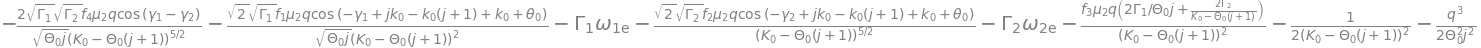

In [57]:
H1.subs(
    
        { 
             l1: genF1["l1"],
             l2: genF1["l2"],
             L1: genF1["L1"],
     
       L2: genF1["L2"],
    }
)

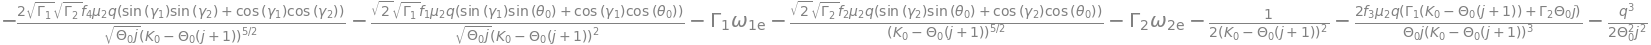

In [58]:
H2 = expand_trig(
    
        
            l1: genF1["l1"],
            l2: genF1["l2"],
            L1: genF1["L1"],
            L2: genF1["L2"],
         
    ).trigsimp()
1: genF1["L1"],
            L2: genF1["L2"],
        }
    ).trigsimp()
)
H2p = 0
for term in H2.args:
    H2p += expand_trig(term.simplify())
H2p
H2 = H2p
H2

In [59]:
X1, X2, Y1, Y2 = symbols("X_1 X_2 Y_1 Y_2")
PBgG = PoissonBracket([g1, g2], [G1, G2])
X1_expr, Y1_expr = sqrt(2 * * G1) * sin(g1), sqrt * 2 * G1) * cos(g1)
X2_expr, Y2_expr = sqrt(2 * * G2) * sin(g2), sqrt * 2 * G2) * cos(g2)
display(PBgG(Y1_expr,  X1_expr).simplify())
display(PBgG(Y2_expr,  X2_expr).simplify())

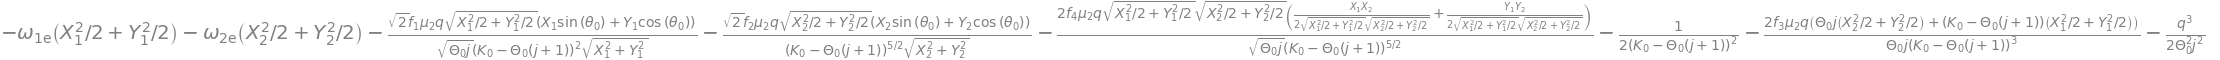

In [60]:
H3 = H2.subs(
    {
        sin(g1): X1 / sqrt(2 * G1),
        cos(g1): Y1 / sqrt(2 * G1),
        sin(g2): X2 / sqrt(2 * G2),
        cos(g2): Y2 / sqrt(2 * G2),
        G1:  Rational(1 2) * ) * (X 1 **2 + Y1**2),
        G2:  Rational(1 2) * ) * (X 2 **2 + Y2**2),
    }
).trigsimp()     # .simplify(deep=True).expand()
H3

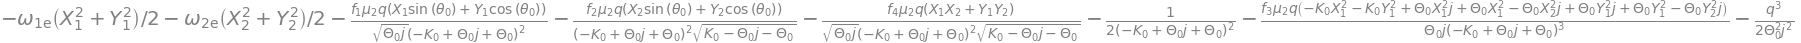

In [61]:
H4 = 0
for term in H3.args:
    H4 += term.cancel().simplify(deep=True).factor()
H4

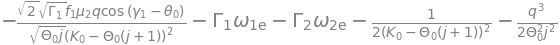

In [97]:
H5 = H2.subs({f3:  0 , f 4:  0,  f2: 0}).trigs imp()  # theta_1 resonance
H5

In [112]:
th1, J1, k1, K1 = symbols("theta_1 J_1 k_1 K_1")
genF2 = {}
genF2["func"] = J1   (g1 - 1 - th0)  +  K1 * th0
genF2["th1"] = genF2["func"].diff(J1)
genF2["k1"] = genF2["func"].diff(K1)
genF2["G1"] = genF2["func"].diff(g1)
genF2["Th0"] = genF2["func"].diff(th0)

genF2["g1"] = solve([genF2["th1"] - th1, genF2["k1"] - k1], [g1, , [g1, th0])[g1]
genF2["th0"] = solve([genF2["th1"] - th1, genF2["k1"] - k1], [g1, , [g1, th0])[th0]
genF2["J1"] = solve([genF2["G1"] - - G1, genF2["Th0 - ] - T [J1,  [J1, K1])[J1]
genF2["K1"] = solve([genF2["G1"] - - G1, genF2["Th0 - ] - T [J1,  [J1, K1])[K1]

for key in genF2.keys():
    display(key, genF2[key])

'func'

'th1'

'k1'

'G1'

'Th0'

'g1'

'th0'

'J1'

'K1'

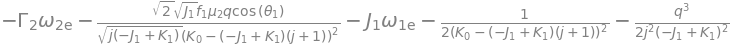

In [113]:
H6 = H5.subs({th0: genF2["th0"], g1: genF2["g1"], Th0: genF2["Th0"], G1: genF2["G1"]})
H6

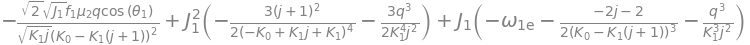

In [322]:
term0 = H6.subs(mu2,  0).taylor_term(2 , J1).simplify().collect(J1**2)
term1 = H6.subs(mu2,  0).taylor_term(1 , J1)
term2 = fraction(H6.args[-1])[0] / fraction(H6.args[-1])[1]subs(J1,  0)
H_red = term0 + term1 + term2
H_red

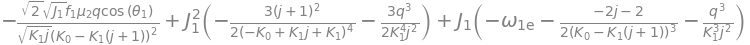

In [308]:
H_red

In [309]:
K0_orbelts = delaunay_to_orbelts(genF1["K0"])
K1_orbelts = delaunay_to_orbelts(genF2["K1"].subs(Th0, genF1["Th0"]))
display(K0_orbelts, K1_orbelts)

In [317]:
K0_K1_func = lambdify([a1, a2, e1, q, j], [K0_orbelts, K1_orbelts])

In [364]:
K0val, K1val = K0_K1_func(alpha0   * 01.0, 1,0 0.0, 0.5, 2)
K0val, K1val

In [371]:
plt.clf()

In [374]:
genF2["J1"]

In [376]:
J1vals = np.linspace(0.0000001,  0.3 , 1000)
a1vals = np.linspace(0.9   alpha0, 1.1 1 alpha0, pha0, 1000)
th1_dot_maxes = np.zeros(len(a1vals))
for kit, a1val in enumerate(a1vals):
    th1_dot_func = lambdify(
         f1val)
    
        [J1, th1, K0, K1, j, q, mu2, om1, om2], H_red.diff(J1).subs(f1, f1val)
    )
  x    
    def func(x):
        e1_from_x = np.sqrt(2 * x / 0.5 / np.sqrt(a1val))

        K0val, K1val = K0_K1_func(a1val, 1, e1_from_x, 0.5, 2)
        return th1_dot_func(x, np.pi, K0val, K1val, 2, 0.5, 1e-3, 0, 0)

    th1_dot_maxes[kit] = np.max(func(J1vals))
plt.plot(a1vals, th1_dot_maxes)

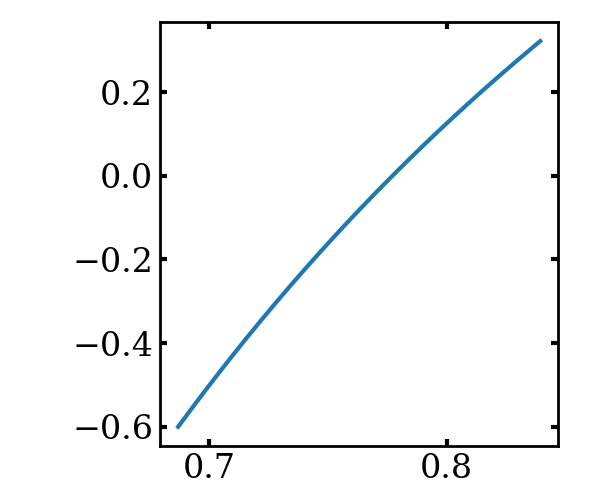

In [370]:
plt.show()

In [369]:
th1_dot_func(0.00001, np.pi, K0val, K1val, 2, 0.5, 1e-3, 0, 0)

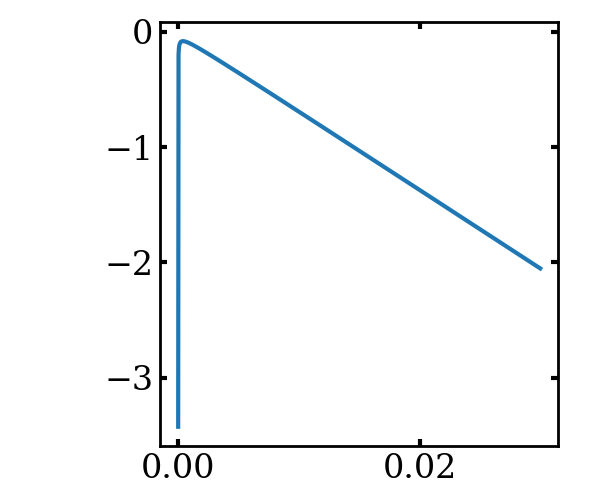

In [367]:
J1vals = np.linspace(0.0000001,  0.03 , 1000)
plt.clf()
plt.plot(J1vals,  func(J1vals))
plt.show()

In [141]:
K0_val = K0_orbelts.subs({a1:  alpha0 , a 2:  1 , q:  0 .5 , j : 2, e1: 0.1})
K1_val = K1_orbelts.subs({a1:  alpha0 , a 2:  1 , q:  0 .5 , j : 2, e1: 0.1})
display(K0_val, K1_val)

In [200]:
Te1, Te2, Tm1, Tm2 = symbols(r"T_{\rm{e}1} T_{\rm{e}2} T_{\rm{m}1} T_{\rm{m}2}")
a1dot_dis = -a1   / Tm1 -   2 * e 1 ** 2  * a1 / Te1
a2dot_dis = -a2   / Tm2 -   2 * e 2 ** 2  * a2 / Te2

e1dot_dis = -e1   / Te1
e2dot_dis = -e2   / Te2

a1dot_dis,  e1dot_dis , a2dot_di s, e2dot_dis

In [231]:
K0_orbelts, K1_orbelts

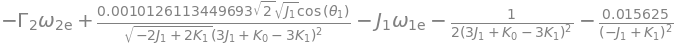

In [230]:
H7 = H6.subs({a1: alpha0, a2: 1, q: 0.5, j: 2, f1:  f1val, mu2 : 1e-3})
H7

In [186]:
J1dot = -H7.diff(th1)
th1dot = -H7.diff(J1)

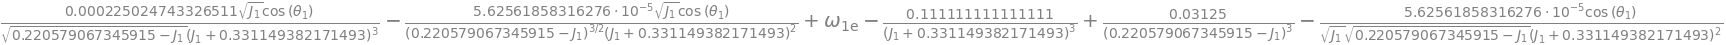

In [187]:
th1dot

In [192]:
func(0.1)

array([16.43635491])

In [196]:
om1vals = np.logspace(-6,  -2 , 100)
J1vals = np.zeros(len(om1vals))
for kit, om1val in enumerate(om1vals):
    th1dot_func = lambdify([J1,  th1 , om1 ], [th1dot])


    def func(x : 0, om1val))

        return np.float64(th1dot_func(x, 0, om1val)) 

    sol = sp.optimize.root_scalar(func, bracket=[0.00001, 0.1])
    J1vals[kit] = sol.root

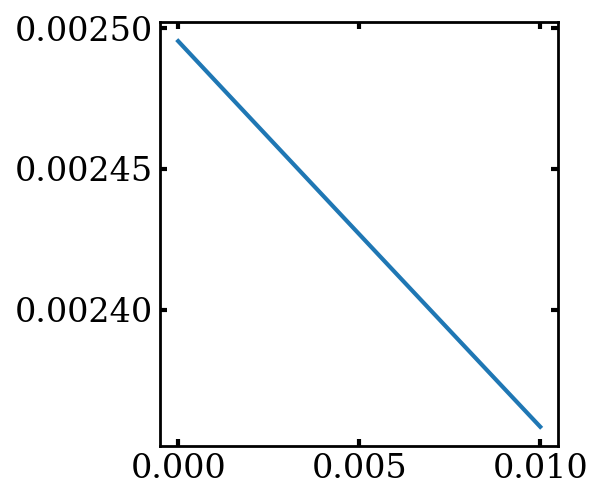

In [199]:
fig, ax = plt.subplots()
ax.plot(om1vals,  J1vals)
fig.tight_layout()

In [83]:
def plugin(expr):
    return expr.subs(
        {
            q: 0.5,
            mu2: 1e-3,
            f1: f1val,
            f2: f2val,
            om1: 0,
            om2: 0,
            j:  2,
        }
    )

# Misc

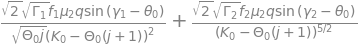

In [86]:
Th0dot = -H5.diff(th0).trigsimp()
Th0dot

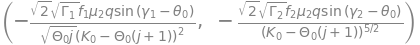

In [89]:
G1dot = -H5.diff(g1).trigsimp()
G2dot = -H5.diff(g2).trigsimp()
G1dot, G2dot

In [ ]:
g1dot = H5.diff(G1).trigsimp()
g2dot = H5.diff(G2).trigsimp()
solve(g1dot   - g2do t, G1)

In [90]:
Th0dot_func = plugin(Th0dot)
G1dot_func  plugin(G1dot)
G2dot_func  plugin(G2dot)

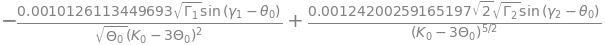

In [91]:
Th0dot_func

In [ ]:
func = lambdify()

In [74]:
Th0dot = -H5.diff(th0)
th0dot = H5.diff(Th0)
X1dot  H5.diff(Y1)
Y1dot= -H5.diff(X1)
X2dot  H5.diff(Y2)
Y2dot  -H5.diff(X2)

In [76]:
K0_expr = genF1["K0"]
K0_expr

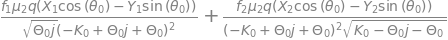

In [81]:
Th0dot

In [71]:
Th0dot_func = plugin(Th0dot)
th0dot_func = plugin(th0dot)
X1dot_func = plugin(X1dot)
Y1dot_func = plugin(Y1dot)
X2dot_func = plugin(X2dot)
Y2dot_func = plugin(Y2dot)

In [80]:
K0_val = np.sqrt(alpha0)   *  ( 1   +  1  / 2) + 1
K0_val

In [ ]:
func = lambdify(
         
   
        
    ,

    [th0, Th0, X1, Y1, X2, Y2],
    [
        Th0dot_func,
    ],
)

# Misc

In [27]:
k1, th2 = symbols("theta_1 theta_2")

In [28]:
H1 = orbelts_to_delaunay(calH).subs(
    {f3: 0, f4: 0, q: 0.5, om1: 0, om2: 0, mu2: 1e-3, f1: f1val, f2: f2val, j:  2}
)

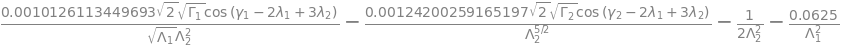

In [29]:
H1

In [30]:
l1dot = H1.diff(L1)
l2dot = H1.diff(L2)
g1dot = H1.diff(G1)
g2dot = H1.diff(G2)

In [31]:
th1dot = 3   * l2dot -   2 * l1dot + gdot
th2dot = 3   * l2dot -   2 * l1dot + g

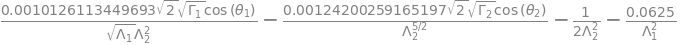

In [32]:
H2 = H1.subs({g1: k1 + 2 * l1 - 3 * l2, g2: th2 + 2 * l1 - 3 * l2})
H2

In [38]:
th1dot   = th1dot.subs({g1: k1 + 2 * l1 - 3 * l2, g2: th2 + 2 * l1 - 3 * l2})
th2dot   = th2dot.subs({g1: k1 + 2 * l1 - 3 * l2, g2: th2 + 2 * l1 - 3 * l2})

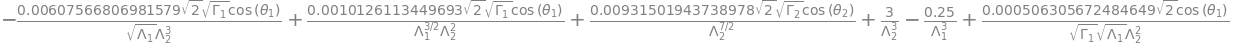

In [39]:
th1dot

In [40]:
L1dot = -H2.diff(l1)
L2dot = -H2.diff(l2)
G1dot = -H2.diff(k1)
G2dot = -H2.diff(th2)

In [41]:
func = lambdify(
    [k1, th2, L1, L2, G1, G2],
    [th1dot, th2dot, L1dot, L2dot, G1dot, G2dot],
)



 def f(Y):
    return func(*Y)

In [43]:
func(0,  0 ,  1,  1,  0.1, 0.1)

In [46]:
sp.optimize.root(f, [np.pi,  0 , 0.7 5,  1,  0.1, 0.1])

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in sqrt
  return [-0.00607566806981579*sqrt(2)*sqrt(Gamma_1)*cos(theta_1)/(sqrt(Lambda_1)*Lambda_2**3) + 0.0010126113449693*sqrt(2)*sqrt(Gamma_1)*cos(theta_1)/(Lambda_1**(3/2)*Lambda_2**2) + 0.00931501943738978*sqrt(2)*sqrt(Gamma_2)*cos(theta_2)/Lambda_2**(7/2) + 3/Lambda_2**3 - 0.25/Lambda_1**3 + 0.000506305672484649*sqrt(2)*cos(theta_1)/(sqrt(Gamma_1)*sqrt(Lambda_1)*Lambda_2**2), -0.00607566806981579*sqrt(2)*sqrt(Gamma_1)*cos(theta_1)/(sqrt(Lambda_1)*Lambda_2**3) + 0.0010126113449693*sqrt(2)*sqrt(Gamma_1)*cos(theta_1)/(Lambda_1**(3/2)*Lambda_2**2) + 0.00931501943738978*sqrt(2)*sqrt(Gamma_2)*cos(theta_2)/Lambda_2**(7/2) + 3/Lambda_2**3 - 0.25/Lambda_1**3 - 0.000621001295825985*sqrt(2)*cos(theta_2)/(sqrt(Gamma_2)*Lambda_2**(5/2)), 0, 0, 0.0010126113449693*sqrt(2)*sqrt(Gamma_1)*sin(theta_1)/(sqrt(Lambda_1)*Lambda_2**2), -0.00124200259165197*sqrt(2)*sqrt(Gamma_2)*sin(theta_2)/Lambda_2**(5/2)]


 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 2.046e+00  2.046e+00  0.000e+00  0.000e+00  6.998e-20
           -0.000e+00]
       x: [ 3.142e+00  0.000e+00  9.169e-01  1.083e+00  2.005e-01
            2.320e-01]
    nfev: 26
    fjac: [[ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [-4.460e-13  4.462e-13 ...  0.000e+00  0.000e+00]
           [-3.475e-17  3.479e-17 ...  0.000e+00  0.000e+00]]
       r: [       nan        nan ...        nan        nan]
     qtf: [ 0.000e+00  0.000e+00 -2.894e+00  1.010e-03  1.590e-16
            1.995e-19]